# Lecture 10. Clustering. KMeans scikit learn implementation.

**Definitions**:   
Kmeans by [your favourite tutor.](https://www.youtube.com/watch?v=lQ39ZRFfYbI)
KMeans is an "unsupervised learning" model => We don't know the labels. We dont' have a "y" target variable. 
The goal is to create groups (clusters) of the observations. The number of groups is unknown. The labels of the groups are uknwon.  
A more accurate description could be "unlabeled learning".

Using what the data suggest, we chose the number of groups and then we think of apporpriate and intuitive labels to describe each cluster (group).     

Important note: The number of groups (clusters) in the end is a matter of policy, a strategic decision based on possible insights of the data.   
It depends on how much we want to "zoom out" or "zoom in" (thanargTM) the data. We may examine and report about the data for different numbers of clusters depending on our needs. Oftenly, there is no "correct" number of clusters.  

Actually, unsupervised learning ["is supervised"](https://www.youtube.com/watch?v=JbP9EPPvVXg) to an extent.   


## Centroids initialization of kmeans and kmeans++
[Scikit-learn example](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_plusplus.html#sphx-glr-auto-examples-cluster-plot-kmeans-plusplus-py)

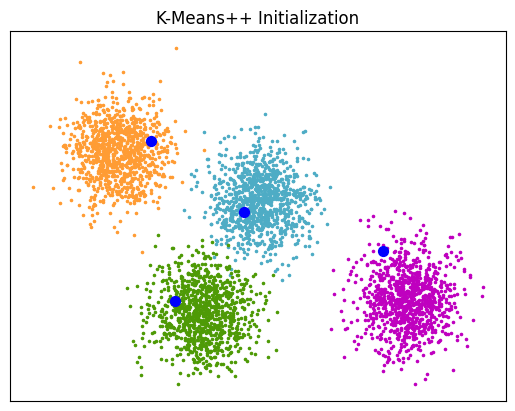

In [91]:
from sklearn.cluster import kmeans_plusplus
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate sample data
n_samples = 4000
n_components = 4

X, y_true = make_blobs(
    n_samples=n_samples, centers=n_components, cluster_std=0.60, random_state=0
)
X = X[:, ::-1]

# Calculate seeds from k-means++
centers_init, indices = kmeans_plusplus(X, n_clusters=4, random_state=0)

# Plot init seeds along side sample data
plt.figure(1)
colors = ["#4EACC5", "#FF9C34", "#4E9A06", "m"]

for k, col in enumerate(colors):
    cluster_data = y_true == k
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1], c=col, marker=".", s=10)

plt.scatter(centers_init[:, 0], centers_init[:, 1], c="b", s=50)
plt.title("K-Means++ Initialization")
plt.xticks([])
plt.yticks([])
plt.show()

## Detailed tutorial on kaggle, improvements, additions by Thanasis Argyriou.
[Tutorial from kaggle](https://www.kaggle.com/satishgunjal/tutorial-k-means-clustering)

## The mall customers dataset, loaded from csv file on your disk.
[Source of the data is Kaggle](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

[Info about dataset](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)  

In [1]:
# use pwd command to see in which folder we are working in.
# pwd means present working directory
# you may need !pwd in Mac OS

In [2]:
pwd  

'C:\\Users\\tharg\\uoa_py_course\\lectures\\ipynb_files\\lecture_10_kmeans'

## 1. Import the necessary modules.   
You may add libraries here as you go on with your work. But, all imports should be at the first code cell.

In [3]:
# data management libraries
import pandas as pd
import numpy as np

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# interactive visualizarion libaries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# scikit learn clustering library
from sklearn.cluster import KMeans
# import the silhouette metric
from sklearn.metrics import silhouette_samples, silhouette_score

## 2. Load the data and understand its features.   
See which are the variables, what is their type, what are the values that the variables take.  
At this step, you should think about possible relations that you ought to examine.   
Which do you think might be more important?

In [6]:
# we name all data as "df" because we have no imagination?
# if your notebook is in the same folder as the data file:
# just use the files name.
# df = pd.read_csv("mall_customers.csv")

# or if you data is inside a folder called data, above your working folder:
# you get extra points for that.
# df = pd.read_csv("../data/mall_customers.csv")
df = pd.read_csv("mall_customers.csv")

# or use an absolute path, that is too ugly, and shows yoy did not study paths:
#df = pd.read_csv("C:\\Users\\tharg\\uoa_python_course_22\\files_22\\lectures_22\\drafts\\ipynb_notebooks_drafts\\ml\\lec_j_kmeans\\mall_customers.csv")


In [7]:
# show first 4 lines of dataset
df.head(4)

CustomerID   Genre  Age  Annual_Income_(k$)  Spending_Score
0           1    Male   19                  15              39
1           2    Male   21                  15              81
2           3  Female   20                  16               6
3           4  Female   23                  16              77

In [8]:
# show column names of dataset.
# 5 columns with suboptimal names.
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual_Income_(k$)', 'Spending_Score'], dtype='object')

In [9]:
# show data types of dataset.
# four numeric, one categorical variable type.
df.dtypes

CustomerID             int64
Genre                 object
Age                    int64
Annual_Income_(k$)     int64
Spending_Score         int64
dtype: object

In [10]:
# simple commnand to show column names and data types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   CustomerID          200 non-null    int64 
 1   Genre               200 non-null    object
 2   Age                 200 non-null    int64 
 3   Annual_Income_(k$)  200 non-null    int64 
 4   Spending_Score      200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### Short summary notes about the variables.
CustomerID is not important, unless you know who is who.  

Spending score is what makes a huge difference. How could we group the customers, according to their spending score, gender, income, age?   

The second most important variable, in this case, should be annual income.  

Gender might, or might might not make a difference.  

Age is a tricky variable. Depending in the issue in question, it might be in linear correlation with the other variables, or it might grow and then gradually fall in importance. e.g. The possibility of deseases and age should be correlated and should grow as age grows. On the other hand, income could grow as age grows but then, after retirement, as age grows income might fall. The same line of thought might apply to age and spending score.   

Conclusion, we want to group customers in clusters. We examine the variables and their relationships. Finally, we separate the customes in clusters.

## 3. Descriptive statistics and Exploratory Data Analysis (EDA)

### 3.1. Descriptive Statistics

In [11]:
# get rid of customer ID column, useless in this case.
df = df.drop("CustomerID", axis=1)

In [12]:
# very basic DStats
df.describe()  # show only numeric variables

Age  Annual_Income_(k$)  Spending_Score
count  200.000000          200.000000      200.000000
mean    38.850000           60.560000       50.200000
std     13.969007           26.264721       25.823522
min     18.000000           15.000000        1.000000
25%     28.750000           41.500000       34.750000
50%     36.000000           61.500000       50.000000
75%     49.000000           78.000000       73.000000
max     70.000000          137.000000       99.000000

In [13]:
# df.describe(include='all')

In [14]:
# Descriptive stats for categorical variables.
df.describe(include=object)

# alternative way to desribe one single column.
#df.Genre.describe()

Genre
count      200
unique       2
top     Female
freq       112

In [15]:
# count number of observations in Genre column.
df.Genre.value_counts()

Female    112
Male       88
Name: Genre, dtype: int64

In [16]:
# count number of observations in Genre column.
df["Genre"].value_counts()

Female    112
Male       88
Name: Genre, dtype: int64

### Short Summary of descriptive statistics about the data.
200 observations.  
Younger is 18, older is 70, mean age is 38.85 (whatever that age means).     
Highest income is 137k, lowest is 15k, mean income is 60.5k. 
The gender distribution is slightly skewed towards "Female", with 112 observations Female and 88 "Male".

### 3.2. Exploratory Data Analysis   
Plot the variables one by one, then in pairs, or by three and see what story the graphs may tell.

In [17]:
# sns.histplot?

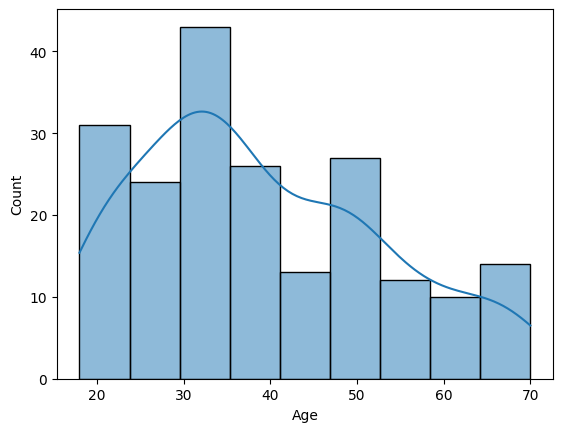

In [18]:
#basic univariate plots.
sns.histplot(x=df["Age"], kde="True");

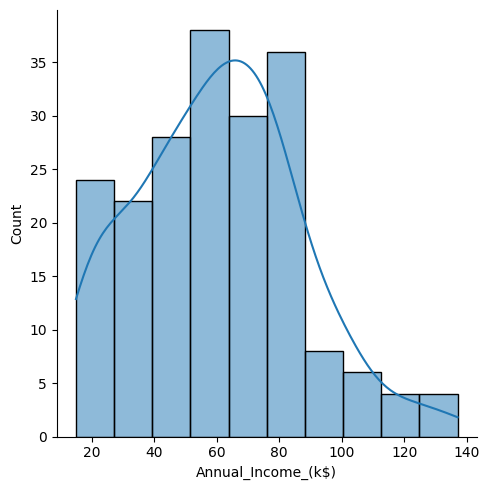

In [19]:
# same as above, different syntax.
sns.displot(x=df["Annual_Income_(k$)"], kde="True");

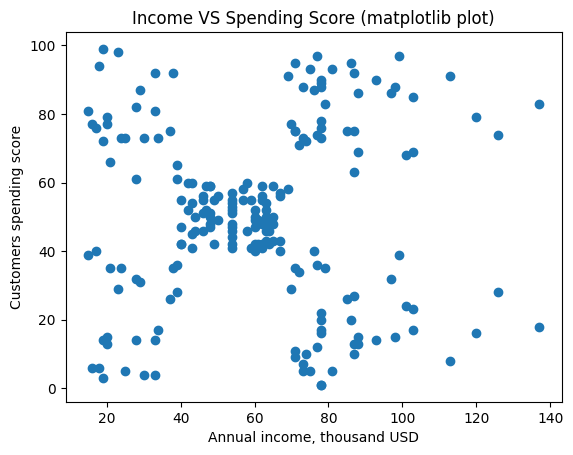

In [20]:
# simple, 'quick and dirty' plot for varibles and their relationships.
# each visualization library has slightly different "syntax" and "names".
# here we use matplotlib library and the scatter() function.
plt.scatter(x=df["Annual_Income_(k$)"], y=df["Spending_Score"])

plt.title("Income VS Spending Score (matplotlib plot)");
plt.ylabel("Customers spending score");
plt.xlabel("Annual income, thousand USD");

We can see 5 or 7 clusters from this plot.

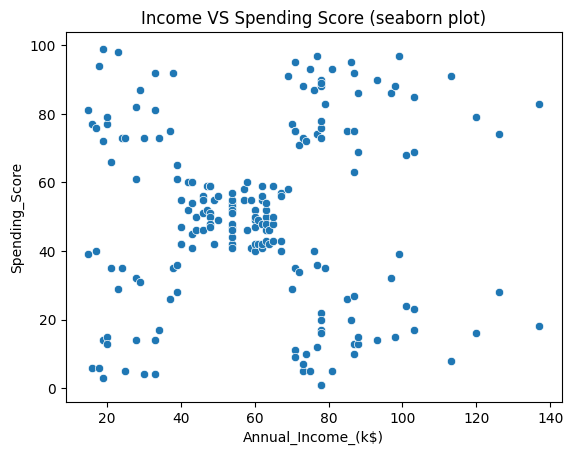

In [21]:
# each visualization library has slightly different "syntax" and "names".
# here we use seaborn library and the scatterplot() function.
sns.scatterplot(x="Annual_Income_(k$)", y="Spending_Score",
                data=df).set(title="Income VS Spending Score (seaborn plot)");

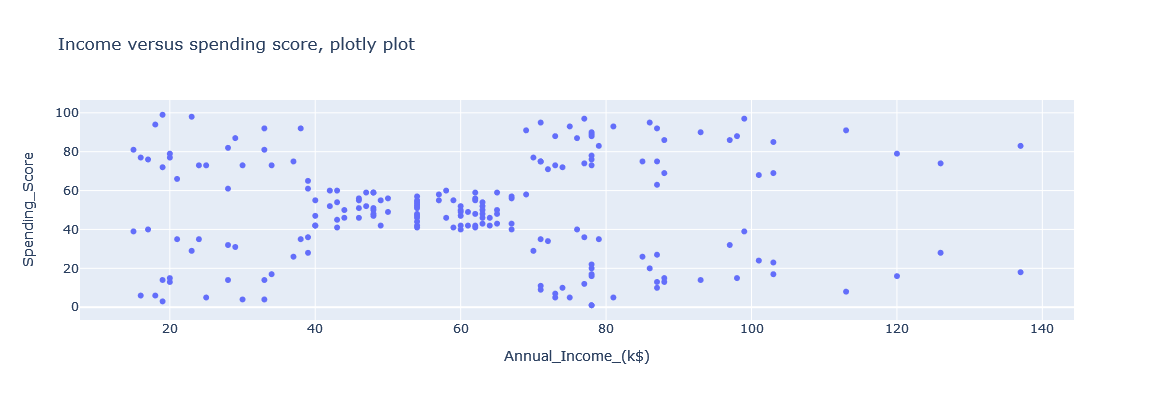

In [22]:
# each visualization library has slightly different "syntax" and "names".
# here we use plotly express library and the scatter() function.
px.scatter(df, x="Annual_Income_(k$)", y="Spending_Score",
           height=400, width=500,
           title="Income versus spending score, plotly plot")

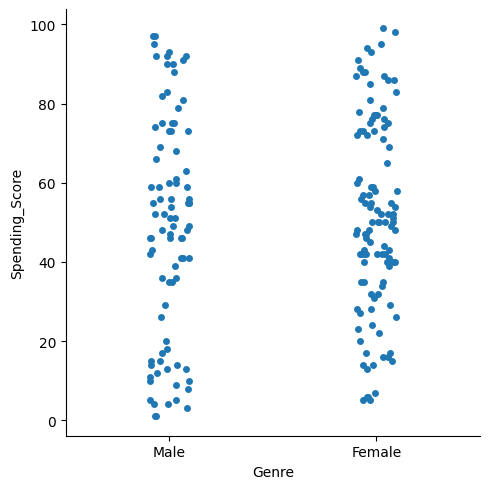

In [23]:
# plot categorical variable with numerical variable.
sns.catplot(x="Genre", y="Spending_Score", data=df);
# not an informative plot for these variables.

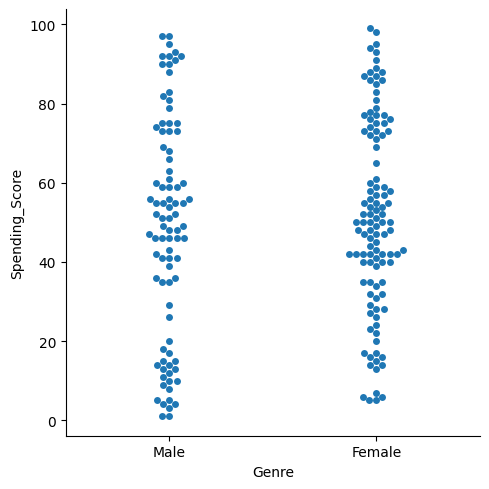

In [24]:
# same as above, different syntax.
sns.catplot(x="Genre", y="Spending_Score", data=df, kind="swarm");
# not an informative plot for these variables.

In [25]:
# same as above, different syntax
# different default values for figure size and spines.
#sns.swarmplot(x="Genre", y="Spending_Score", data=df);
# not an informative plot for these variables.

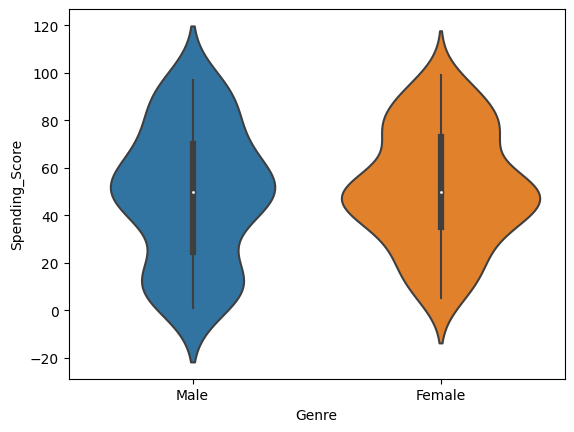

In [26]:
sns.violinplot(x="Genre", y="Spending_Score", data=df);
# not very informative plot for these variables.
# But, we see more observations of type female towards the median.

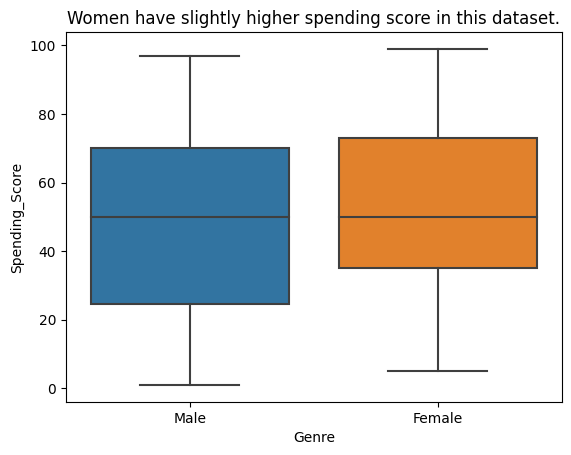

In [27]:
sns.boxplot(x="Genre", y="Spending_Score",
            data=df).set(
    title="Women have slightly higher spending score in this dataset.");

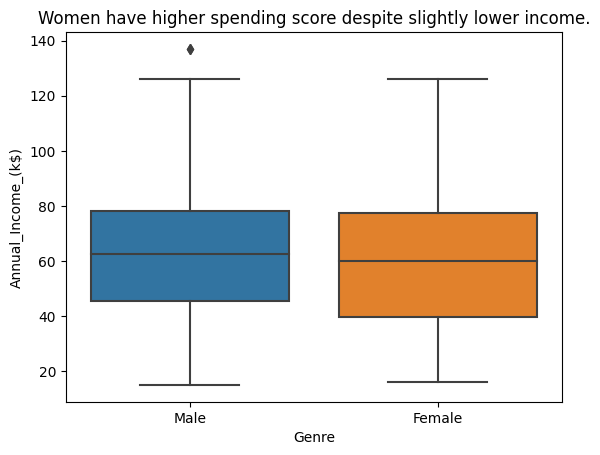

In [28]:
sns.boxplot(x="Genre", y="Annual_Income_(k$)",
            data=df).set(
    title="Women have higher spending score despite slightly lower income.");

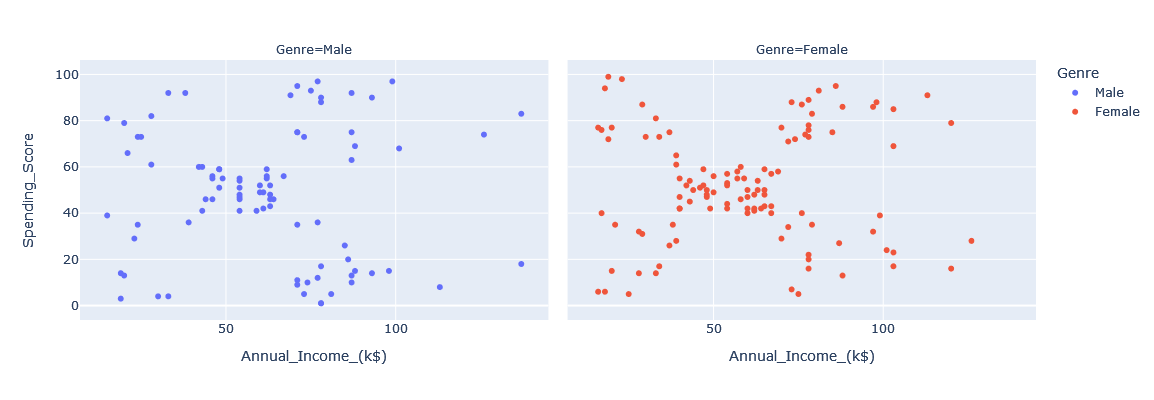

In [29]:
# not a big difference it seems, but plots are not good enough for small differences.
px.scatter(df, x="Annual_Income_(k$)", y="Spending_Score",
           facet_col="Genre", color="Genre", height=400, width=800)

#### Simple descriptive stats on the mean and median of the two genders also shows preliminary evidence of only a small difference.   
Plots are not good enough for small differences.

In [30]:
# show mean income by gender. Female average income is lower.
df.groupby('Genre', as_index=False)['Annual_Income_(k$)'].mean()

Genre  Annual_Income_(k$)
0  Female           59.250000
1    Male           62.227273

In [31]:
# show mean income and spending score by gender
df.groupby('Genre')[['Annual_Income_(k$)', 'Spending_Score']].mean()

Annual_Income_(k$)  Spending_Score
Genre                                     
Female           59.250000       51.526786
Male             62.227273       48.511364

In [32]:
# show median of income and spending score by gender
df.groupby('Genre')[['Annual_Income_(k$)', 'Spending_Score']].median()

Annual_Income_(k$)  Spending_Score
Genre                                     
Female                60.0            50.0
Male                  62.5            50.0

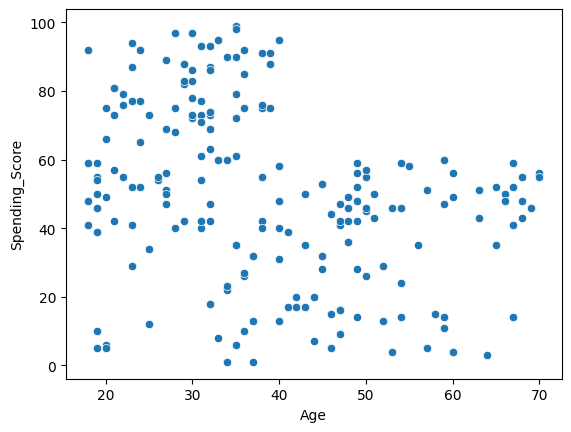

In [33]:
# plot Age and Score.
sns.scatterplot(x="Age", y="Spending_Score", data=df);
# No one above 40 years old has spending score > 60

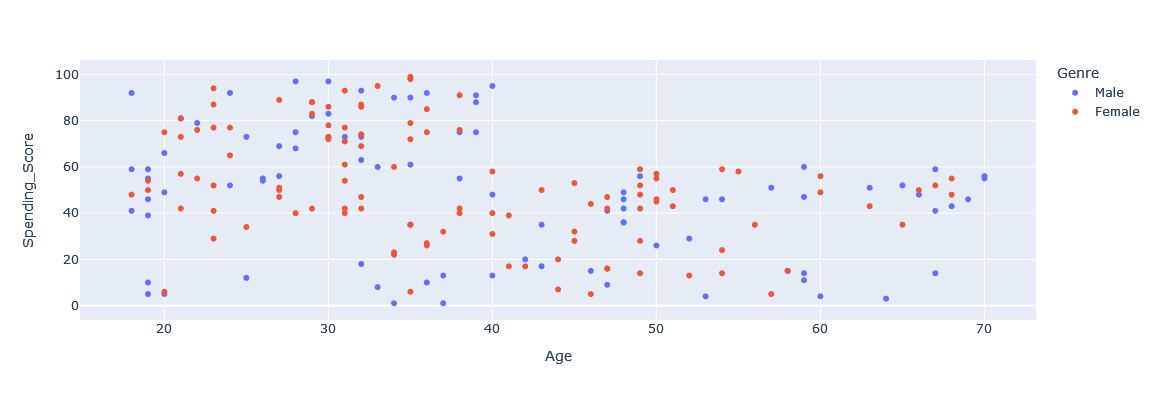

In [34]:
# plot Age and Score and add some color to your gender life.
px.scatter(df, x="Age", y="Spending_Score", color="Genre",
           height=500, width=700)

No one above 40 years old has spending score > 60.  
Very few customers below 30 years old have low spending score < 40.  
The highest spending scores appear to be also a matter of age and not olny a matter of income.   
This is the first tutorial that shows this (conclusion after reading dozens of tutorials on kaggle).

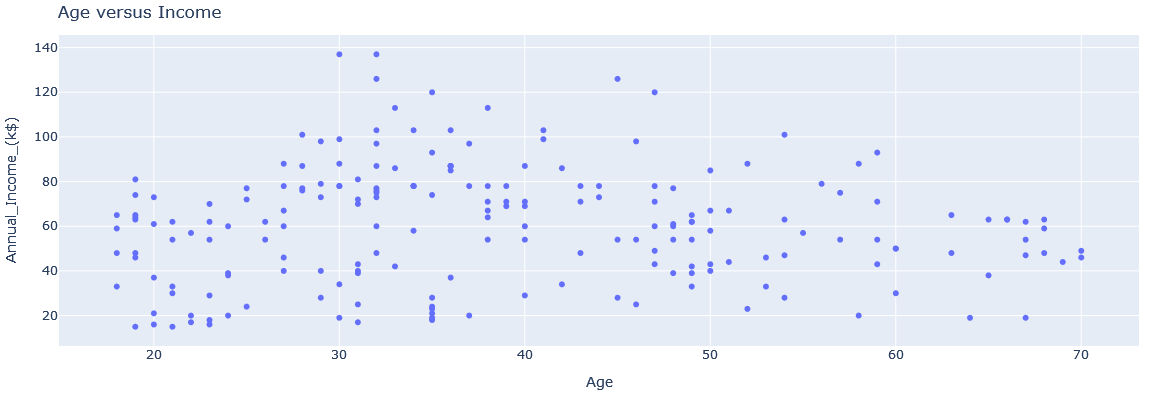

In [35]:
# each visualization library has slightly different "syntax" and "names".
# here we use plotly express library and the scatter() function.
#see how to use tight layout margins.
px.scatter(df, x="Age", y="Annual_Income_(k$)",
           height=400, width=600,
          title="Age versus Income"
          ).update_layout(margin=dict(t=35, l=15, r=15, b=15))

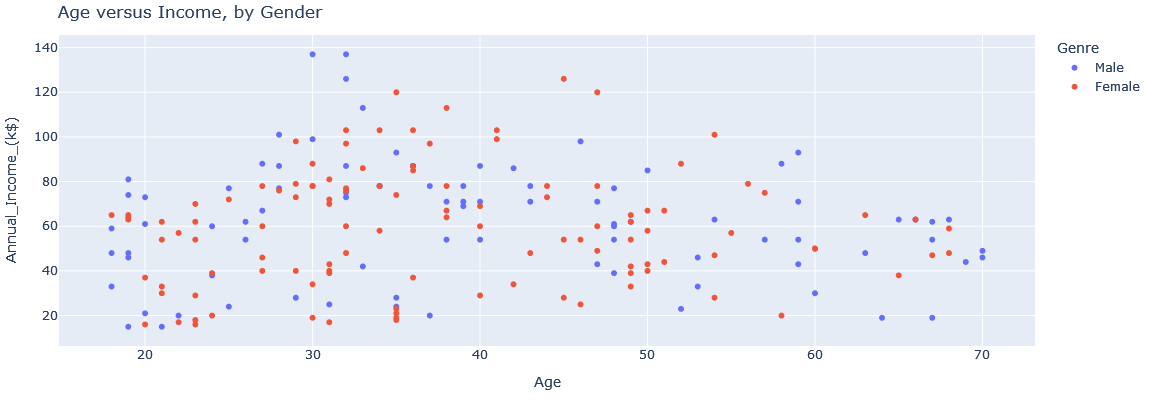

In [36]:
px.scatter(df, x="Age", y="Annual_Income_(k$)", color="Genre",
           height=400, width=600,
          title="Age versus Income, by Gender"
          ).update_layout(margin=dict(t=35, l=15, r=15, b=15))

The plots above confirm that there are no customers aged 20 to 27 with income above 90. Still, there are many in this age bin with the highest spending scores.

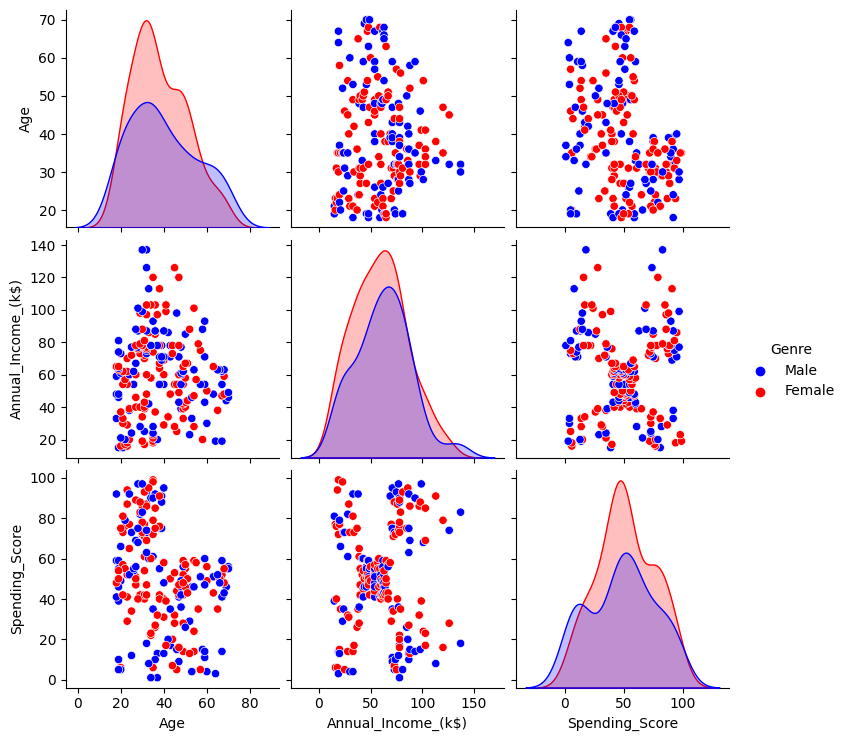

In [37]:
sns.pairplot(data=df, hue='Genre', palette=['Blue', 'Red']);

The plot above shows a bit higher spending score for women.  
The higher distribution peaks for female are there because there are more "female" observations.    
The distribution of spending score for women is a bit shifted to the right (bottom right plot). But, that difference is again very small and might be only true only in this small dataset.

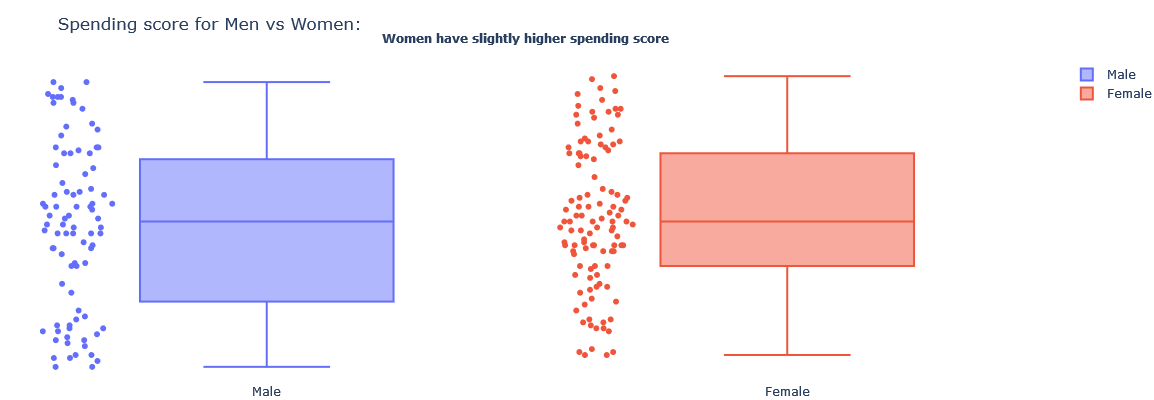

In [38]:
fig = make_subplots(rows=1, cols=2, horizontal_spacing=False, shared_yaxes=True)

fig.append_trace(go.Box(y=df[df['Genre']=='Male']['Spending_Score'],
                        name='Male', boxpoints='all'), row=1, col=1)

fig.append_trace(go.Box(y=df[df['Genre']=='Female']['Spending_Score'],
                        name='Female', boxpoints='all'), row=1, col=2)

fig.update_layout(title='Spending score for Men vs Women:',
                 plot_bgcolor='#fff',
                 yaxis=dict(showticklabels=False),
                 height=400, width=600,
                 ).update_layout(margin=dict(t=60, l=5, r=0, b=15))

fig.add_annotation(x=0.5, y=1.1, text='<b>Women have slightly higher spending score</b>',
                   xref='paper', yref='paper', showarrow=False)
fig.show()

### Plot 4 dimensions (4 features) on the 3D space.   
Try different views, angles, perspectives, zooms to see how the data points look like.
There are at least five clusters and the middle one appears more densely populated.

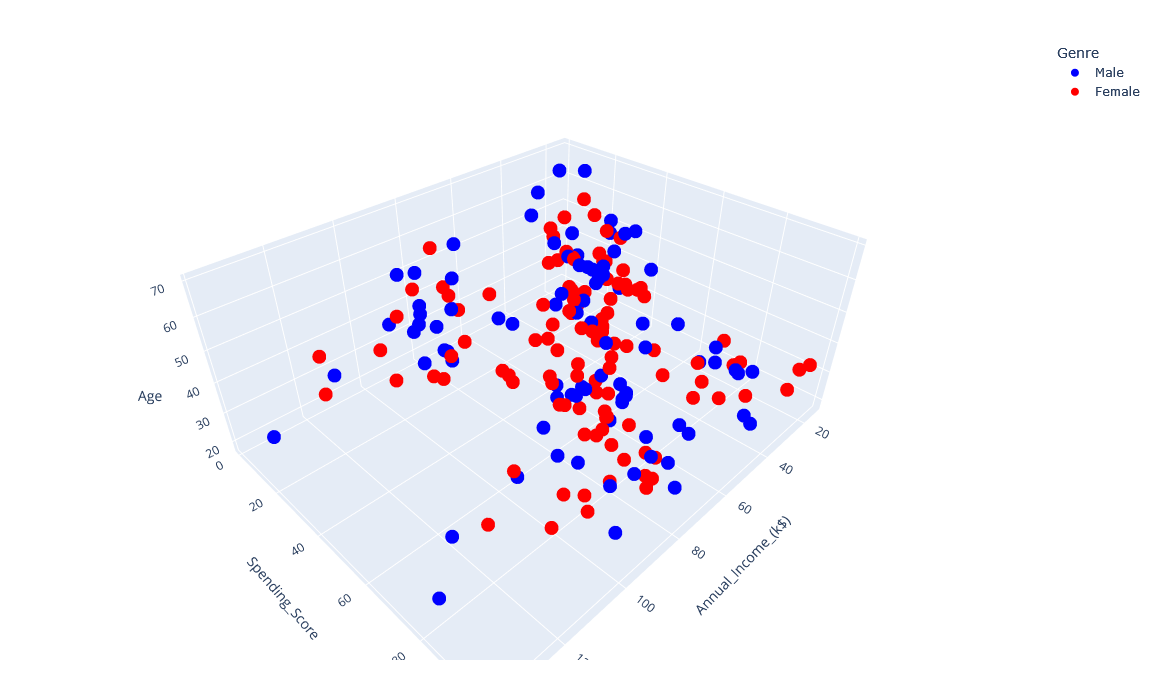

In [39]:
three_dim_fig = px.scatter_3d(
    df, x="Annual_Income_(k$)", y="Spending_Score", z="Age", color="Genre",
    height=700, width=700,
    color_discrete_map={"Male": "blue", "Female":"red"}
).update_layout(margin=dict(t=40, l=40, r=40, b=40)
               )#.update_scenes(xaxis_autorange="reversed")

three_dim_fig.show()

# save to file, use everywhere with a browser
three_dim_fig.write_html("three_dim_customers.html")  

#### This plot confirms that ALL the customers with low annual income and high spending score belong to a relatively young age, < 35 years old

### Write an EDA and Descriptive Stats summary about variables their relationships.
...  
...  
...  
...  


## 4. Apply KMeans clustering to the data
##$ 4.1. Apply KMeans using two variables (Income and Spending Score) and five clusters.

Note: For simplicity reasons, I do not split the data in train and test set.

In [40]:
# create a matrix (πίνακας) of two varibles.
X = df[['Annual_Income_(k$)', 'Spending_Score']]

In [41]:
# show first 3 lines of dataff
X.head(3)

Annual_Income_(k$)  Spending_Score
0                  15              39
1                  15              81
2                  16               6

In [42]:
# call the Kmeans algo to initialize it, and customise it with 5 clusters
# set random_state to always generate the same results
model = KMeans(n_clusters=5, random_state=0)

In [43]:
# show what the above variable name has created
model

KMeans(n_clusters=5, random_state=0)

In [44]:
# fit the 5 clusters customized algorithm to the data.
fitted_kmeans = model.fit(X)

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [45]:
# create y_pred = assign each observation of X to a cluster
y_pred = fitted_kmeans.predict(X)

In [46]:
## all the commands above could be in one line:
y_pred = KMeans(n_clusters=5).fit_predict(X)

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [47]:
# show the clusters in which each observation has been assigned to
y_pred

array([4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1,
       4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 2,
       4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 3, 0, 2, 0, 3, 0, 3, 0,
       2, 0, 3, 0, 3, 0, 3, 0, 3, 0, 2, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0,
       3, 0])

#### Assign ("predict") a cluster for one or more new observations.

In [50]:
# predict the cluster of a new observation that has annual income 20 and spending score 50.
new_observation = [[20, 50]]
#prediction
new_observation_pred = fitted_kmeans.predict(new_observation)
# this belongs in the cluster with label 4
new_observation_pred

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



array([4])

In [56]:
new_observation_as_a_df = pd.DataFrame(
    new_observation, columns=['Annual_Income_(k$)', 'Spending_Score'])

fitted_kmeans.predict(new_observation_as_a_df)

array([4])

#### Show observations in clusters in a table.

In [63]:
# create a new column, add the column to the dataframe to show the cluster of each observation.
df["cluster"] = pd.DataFrame(
    y_pred, columns=["cluster"])

# set cluster column values as category data type
df["cluster"] = df["cluster"].astype('category')

#show first 6 rows of observations
df.head(6)

Genre  Age  Annual_Income_(k$)  Spending_Score cluster
0    Male   19                  15              39       4
1    Male   21                  15              81       1
2  Female   20                  16               6       4
3  Female   23                  16              77       1
4  Female   31                  17              40       4
5  Female   22                  17              76       1

In [58]:
# count number of observations in each cluster, sorted by number of observations
df['cluster'].value_counts()

2    81
0    39
3    35
4    23
1    22
Name: cluster, dtype: int64

In [59]:
# same as above, different syntax, output sorted by cluster number
df.groupby('cluster').size()

cluster
0    39
1    22
2    81
3    35
4    23
dtype: int64

In [64]:
# Show average of variables my cluster
# This shows some basic descriptive stats about the clusters.
# e.g. cluster 3 has the highest spending score (82) with average income=82k and age=32
# e.g. cluster 0 has almost highest spending score (79) with average income only 26k and age=25
# This IMPORTANT finding confirms the previous insight about the importance of age.
df.groupby('cluster').mean()

C:\Users\tharg\AppData\Local\Temp\ipykernel_4132\583208260.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Age  Annual_Income_(k$)  Spending_Score
cluster                                               
0        32.692308           86.538462       82.128205
1        25.272727           25.727273       79.363636
2        42.716049           55.296296       49.518519
3        41.114286           88.200000       17.114286
4        45.217391           26.304348       20.913043

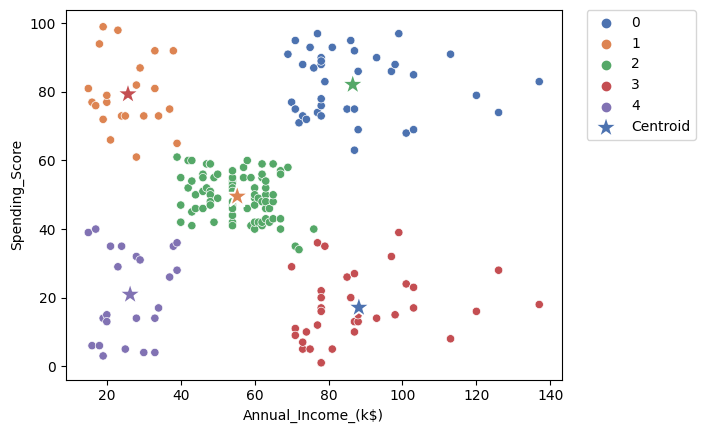

In [65]:
# plot the clusters with their centroids
sns.scatterplot(x="Annual_Income_(k$)", y="Spending_Score", hue="cluster",
                data=df, palette="deep");

sns.scatterplot(x=fitted_kmeans.cluster_centers_[:, 0],
                y=fitted_kmeans.cluster_centers_[:, 1],
                s=300, c=sns.color_palette("deep", 5),
                label='Centroid', marker='*');

# Put the legend outside of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);

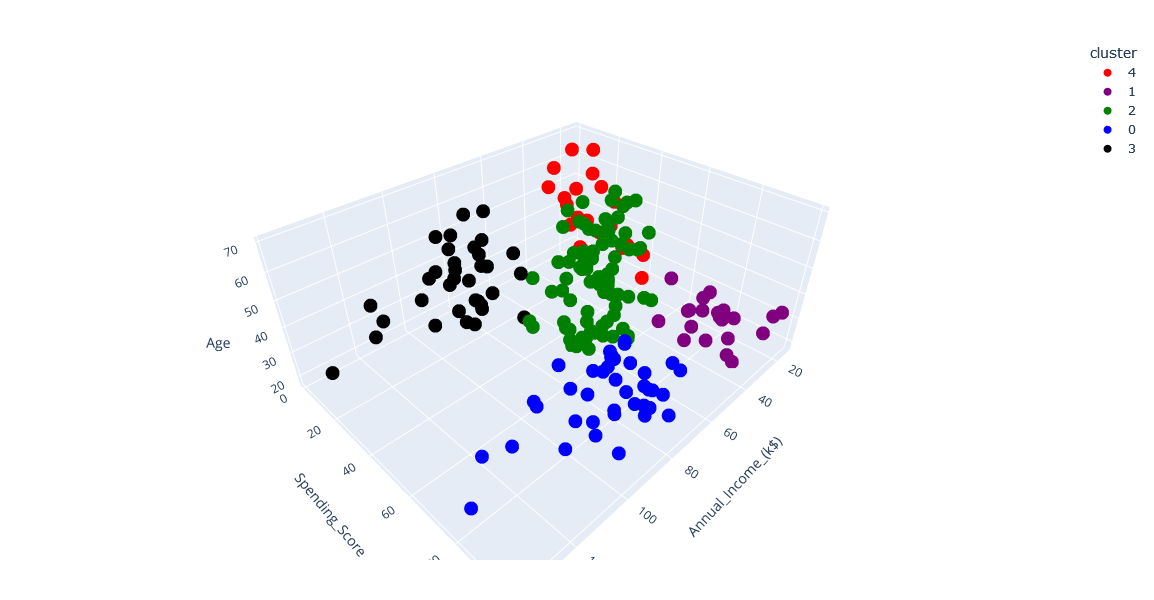

In [66]:
# plot the five clusters in 3D space
three_dim_clusters = px.scatter_3d(
    df, x="Annual_Income_(k$)", y="Spending_Score", z="Age", color="cluster",
    height=600, width=600,
    color_discrete_map={0: "blue", 1:"purple", 2:"green", 3:"black", 4:"red"}
).update_layout(margin=dict(t=40, l=40, r=40, b=40))

three_dim_clusters.show()

# save to file, use everywhere with a browser
#three_dim_clusters.write_html("three_dim_customers.html")  

### 4.2. Use the elbow method to get a "suggestion" about the number of clusters.  
This should be done first, but for presentation, learning reasons I wanted to show how kmeans is applied in scikit learn. Use all features.

In [67]:
df.columns

Index(['Genre', 'Age', 'Annual_Income_(k$)', 'Spending_Score', 'cluster'], dtype='object')

In [68]:
# create matrix of features to use in algorithm
X = df[["Genre", "Age", "Annual_Income_(k$)", "Spending_Score"]]
# show first two rows.
X.head(2)

Genre  Age  Annual_Income_(k$)  Spending_Score
0  Male   19                  15              39
1  Male   21                  15              81

In [69]:
# encode Male and Female to zero and one, to use this feature in the Kmeans algo
# create a new column named Gender and set Male = 1, Female=0
X["Gender"] = pd.get_dummies(X.Genre, drop_first=True, prefix="Genre")
X.head(3)

Genre  Age  Annual_Income_(k$)  Spending_Score  Gender
0    Male   19                  15              39       1
1    Male   21                  15              81       1
2  Female   20                  16               6       0

In [70]:
# drop the Genre column from X.
X = X.drop("Genre", axis=1)
# show first 3 rows
X.head(3)

Age  Annual_Income_(k$)  Spending_Score  Gender
0   19                  15              39       1
1   21                  15              81       1
2   20                  16               6       0

### Apply Kmeans with four features and 1 to 10 clusters, to demonstreate the elbow method.

In [71]:
# empty list to contain the score of each cluster.
clustering_score = []

# loop from 1 to 10 clusters:
for clusters_number in range(1, 11):
    # initiate and customize algo
    model = KMeans(n_clusters=clusters_number, random_state=0)
    # fit algo to the data
    model.fit(X)
    # inertia_ = Sum of squared distances of samples to their closest cluster center.
    # this is the Within Clusters Sum of Squares metric, WCSS
    clustering_score.append(model.inertia_)
   

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-pa

In [72]:
# show the list with the clusters' score from 1 to 10
clustering_score

[308862.05999999994,
 212889.442455243,
 143391.59236035674,
 104414.67534220166,
 75399.61541401484,
 58348.64136331505,
 51132.7032125769,
 44392.115665679354,
 41000.874221320715,
 37649.692254297435]

In [73]:
# WCSS score for 1 cluster
clustering_score[0]  # first item in the list

308862.05999999994

In [74]:
# WCSS score for 2 clusters
clustering_score[1]  # second item in the list

212889.442455243

In [75]:
# show the cluster score for the fifth element (5 clusters)
clustering_score[4]

75399.61541401484

In [76]:
# creata pandas dataframe from list of clustering WCSS score
wcss_df = pd.DataFrame({'clusters_score':clustering_score})

In [77]:
# creata new column of dataframe from range of clusters
wcss_df["clusters_number"] = pd.Series(range(1,11))

In [78]:
#show clusters score for number of clusters
wcss_df

clusters_score  clusters_number
0   308862.060000                1
1   212889.442455                2
2   143391.592360                3
3   104414.675342                4
4    75399.615414                5
5    58348.641363                6
6    51132.703213                7
7    44392.115666                8
8    41000.874221                9
9    37649.692254               10

We see that from 4 to five clusters there is a large reduction in WCSS, but from 5 to 6 there is a reduction from 58348 to 51132, much smaller. The reduction in WCSS from 6 to 7 clusters is similar.
There is a much smaller reduction from 7 to 8 clusters.

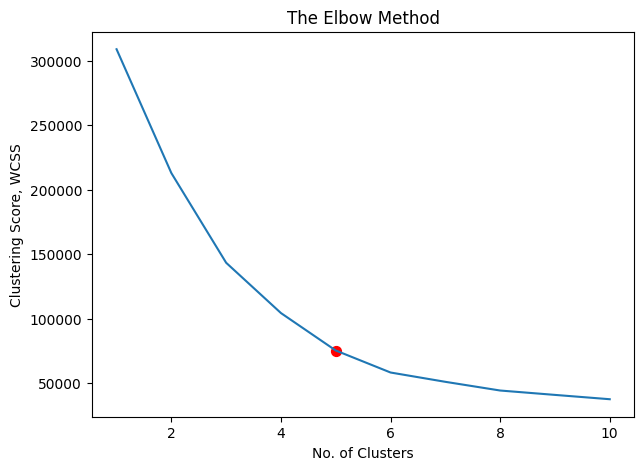

In [79]:
# plot WCSS
# create a figure and set size
plt.figure(figsize=(7,5))

#plot the simple range from 1 to 10 on x and the clustering score on y.
plt.plot(range(1, 11), clustering_score)

#plot a red o on number 5 on x axis, and the WCSS score 
plt.scatter(5, clustering_score[4], s = 50, c = 'red', marker='o')

# add title and labels
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Clustering Score, WCSS');

We also see that the slope of the curve from 5 to 6 clusters is reduced but very slightly. This suggests five clusters are a good choice.
But using four features instead of two suggest that 6 cluster might also be a good choice.

### 4.3. Apply silhouette method to get a suggestion for the number of clusters.  
scikit-learn silhouette score [function and examples.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

For a more advanced reading on silhouette score you may read this [tutorial.](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)   

For more advanced clustering performace evaluation methods, you may read this [guide.](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

In [80]:
#create empty list to store score
silhouette_scores_list = []

# loop from 2 to 10 clusters:
for clusters_number in range(2, 11):
    # initiate and customize algo
    model = KMeans(n_clusters=clusters_number, random_state=0)
    # fit algo to the data
    clusters = model.fit_predict(X)
    # calculate silhouette score for each number of clusters
    silhouette_metric_score = silhouette_score(X, clusters)
    # append each score to the list
    silhouette_scores_list.append(silhouette_metric_score)
    print(
        f"For clusters={clusters_number}, the average silhouette_score is: {silhouette_metric_score}")

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-pa

For clusters=2, the average silhouette_score is: 0.29307334005502633
For clusters=3, the average silhouette_score is: 0.383798873822341
For clusters=4, the average silhouette_score is: 0.4052954330641215
For clusters=5, the average silhouette_score is: 0.4440669204743008
For clusters=6, the average silhouette_score is: 0.45205475380756527
For clusters=7, the average silhouette_score is: 0.44096462877395787
For clusters=8, the average silhouette_score is: 0.4277721345758326
For clusters=9, the average silhouette_score is: 0.4009199511597155
For clusters=10, the average silhouette_score is: 0.3786785930395736


C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



We get a higher silhouette score for 5 clusters. But only by a tiny difference.

### 4.4. Apply KMeans with four features and six clusters

In [81]:
# our data until now, grouped in 5 clusters
df.head(3)

Genre  Age  Annual_Income_(k$)  Spending_Score cluster
0    Male   19                  15              39       4
1    Male   21                  15              81       1
2  Female   20                  16               6       4

In [82]:
#show the features matrix
X.head(3)
# remember we have encoded "Genre" as "Gender".

Age  Annual_Income_(k$)  Spending_Score  Gender
0   19                  15              39       1
1   21                  15              81       1
2   20                  16               6       0

In [83]:
model = KMeans(n_clusters=6, random_state=0)
# fit algo to the data
six_clusters_grouping = model.fit_predict(X)

C:\Users\tharg\uoa_py_course\course_venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [84]:
# create a new column, add it to the dataframe to show cluster sof observations.
df["six_clusters"] = pd.DataFrame(
    six_clusters_grouping, columns=["six_clusters"])

# set six clusters column values as category data type
df["six_clusters"] = df["six_clusters"].astype('category')

In [85]:
# show first 4 rows
df.head(4)

Genre  Age  Annual_Income_(k$)  Spending_Score cluster six_clusters
0    Male   19                  15              39       4            5
1    Male   21                  15              81       1            4
2  Female   20                  16               6       4            5
3  Female   23                  16              77       1            4

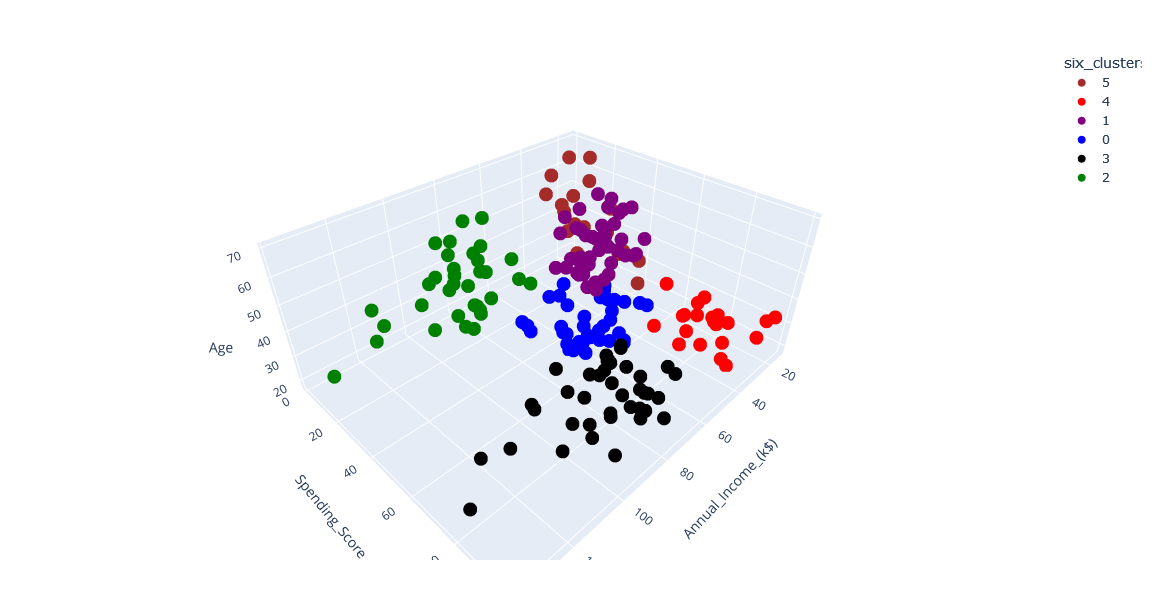

In [86]:
# plot the six clusters in the 3D space
three_dim_six_clusters = px.scatter_3d(
    df, x="Annual_Income_(k$)", y="Spending_Score", z="Age",
    color="six_clusters", height=600, width=600,
    color_discrete_map={
        0: "blue", 1:"purple", 2:"green", 3:"black", 4:"red", 5:"brown"}
).update_layout(margin=dict(t=50, l=60, r=60, b=40))

three_dim_six_clusters.show()

# save to file, use everywhere with a browser
#three_dim_clusters.write_html("three_dim_customers.html")  

Examining the data, we see that the customers with spending score 40 to 60 have been devided to two clusters, based on their age. The new cluster mainly contains customers above 40+ with high spending score. It is designated as cluster 1 in this case, and this the larger cluster.  

**Important reminder: at the end end of the writting (lol), the number of clusters is also a matter of policy decisions.**

In [87]:
# show clusters by size
df.groupby('cluster').size()

cluster
0    39
1    22
2    81
3    35
4    23
dtype: int64

In [88]:
# show first 5 rows of observations that belong to cluster 1.
df[df["six_clusters"] == 1].head()

Genre  Age  Annual_Income_(k$)  Spending_Score cluster six_clusters
40  Female   65                  38              35       4            1
42    Male   48                  39              36       4            1
46  Female   50                  40              55       2            1
50  Female   49                  42              52       2            1
53    Male   59                  43              60       2            1

In [89]:
# show basic descriptive stats for cluster labeled as 1.
df[df["six_clusters"] == 1].describe()

Age  Annual_Income_(k$)  Spending_Score
count  45.000000           45.000000       45.000000
mean   56.155556           53.377778       49.088889
std     8.543886            8.435016        6.251626
min    43.000000           38.000000       35.000000
25%    49.000000           47.000000       45.000000
50%    54.000000           54.000000       49.000000
75%    65.000000           62.000000       55.000000
max    70.000000           67.000000       60.000000

In [90]:
# group cluster labeled as 1, by gender and show size
df[df["six_clusters"] == 1].groupby("Genre").size()

Genre
Female    25
Male      20
dtype: int64

## 5. Model pereformance evaluation in clustering.  
[Scikit-learn model evaluation and metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#metrics-and-scoring-quantifying-the-quality-of-predictions)   
[Clustering performance evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)   
If there are no labels indeed use:   
[Silhouette Coefficient](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)  
[Calinski-Harabasz index](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index)

## 6. Extra reading about clustering and unsupervised learning.
“Give a man a fish and you feed him for a day. Teach him how to fish and you feed him for a lifetime”, quote from the Chinese philosopher Lao Tzu, founder of Taoism.  
How to destroy a proverb, by Thanasis Argyriou:  
“Give a student a coding script and you solve his problems for an exam. Teach him how to chatGPT, google search and copy-paste and you ***might*** solve his problems for a lifetime of exams.”  
[Unsupervised learning algorithms in scikit learn.](https://scikit-learn.org/stable/unsupervised_learning.html)  
[Clustering algorithms in scikit learn.](https://scikit-learn.org/stable/modules/clustering.html#)